# Evaluation of Northwind Trading Company

The aim of this project is the evaluate the health of the Northwind Trading Company based on several fronts. First, the effectiveness of their discounts in resulting larger quantity orders and higher total order prices. Additionally, customer contact types will be evaluated to determine if certain types of contacts place larger orders with the company, and thus to suggest that similar types of contacts should be sought within prospective customer companies. Reaching out to a customer and finalizing a sale is meaningless if Northwind is failing logistically to get the product to the customer. For this reason, the cost and speed of shipping will be analyzed to determine if improvements can be made to streamline its practice. Lastly, an evaluation of the sales numbers of a sample of employees will be used to make recommendations on changes to current training protocols in an effort increase productivity.

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
from scipy import stats
import numpy as np
import itertools
import pandas as pd

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


In [4]:
import datetime as dt
from datetime import date

In [5]:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [6]:
inspector = inspect(engine)

2019-04-06 20:50:36,102 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-06 20:50:36,103 INFO sqlalchemy.engine.base.Engine ()
2019-04-06 20:50:36,105 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-06 20:50:36,105 INFO sqlalchemy.engine.base.Engine ()


In [7]:
con = engine.connect()

In [8]:
def col_names(table):
    
    '''Return a list of the column names from a table.
        table: string that exactly matches the name of the table'''
    
    # Store the column names in a list
    name_list = []
    
    # Use the get_columns inspector attribute to get a dictonary of columns
    names = inspector.get_columns(table)
    
    # Loop through the dictionary 'name' key to get the column names and append them to name_list
    for element in names:
        name_list.append(element.get('name'))
        
    return name_list

In [9]:
def make_df(table, cols):
    
    '''Create a dataframe from an ORM table, with the option to select specific columns from that table. To return
    all columns from a table, set cols equal to None.
    
    table: String that exactly matches the table name
    cols: String of column names'''
    
    # Return all columns from table if cols parameter equals None
    if cols == None:
        
        # Creates the dataframe
        return pd.read_sql_query(f'SELECT * FROM {table}', engine)
    
    # Return specified columns from table
    else:
        
        # Creates the dataframe
        return pd.read_sql_query(f'SELECT {cols} FROM {table}', engine)
    

In [10]:
def join_2 (table1, table2, cols, on):
    
    '''Create a dataframe from the joining of two ORM tables. User may specify specific columns to include.
    
    table1: String exactly matching the table name followed by its allias (if necessary)
    table2: String exactly matching the table name followed by its allias (if necessary)
    cols: String of column names (with appropriate allias) to include in dataframe
    on: String indicating what columns (with appropriate allias) to join table1 and table2'''
    
    # Return all columns from table if cols parameter equals None
    if cols == None:
        
        # Creates the dataframe
        return pd.read_sql_query(f"SELECT * FROM {table1} JOIN {table2} on {on}", engine)
    
    # Return specified columns from table
    else:
        
        # Creates the dataframe
        return pd.read_sql_query(f"SELECT {cols} FROM {table1} JOIN {table2} on {on}", engine)
    
    
def join_3 (table1, table2, table3, cols, on1, on2):
    
    '''Create a dataframe from the joining of three ORM tables. User may specify specific columns to include.
    
    table1: String exactly matching the table name followed by its allias (if necessary)
    table2: String exactly matching the table name followed by its allias (if necessary)
    table3: String exactly matching the table name followed by its allias (if necessary)
    cols: String of column names (with appropriate allias) to include in dataframe
    on1: String indicating what columns (with appropriate allias) to join table1 and table2
    on2: String indicating what columns (with appropriate allias) to join table2 and table3'''
    
    # Return all columns from table if cols parameter equals None
    if cols == None:
        
        # Creates the dataframe
        return pd.read_sql_query(f"SELECT * FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2}", engine)
    
    # Return specified columns from table
    else:
        
        # Creates the dataframe
        return pd.read_sql_query(f"SELECT {cols} FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2}", engine)
    
    
def join_4 (table1, table2, table3, table4, cols, on1, on2, on3):
        
    '''Create a dataframe from the joining of four ORM tables. User may specify specific columns to include.
    
    table1: String exactly matching the table name followed by its allias (if necessary)
    table2: String exactly matching the table name followed by its allias (if necessary)
    table3: String exactly matching the table name followed by its allias (if necessary)
    table4: String exactly matching the table name followed by its allias (if necessary)
    cols: String of column names (with appropriate allias) to include in dataframe
    on1: String indicating what columns (with appropriate allias) to join table1 and table2
    on2: String indicating what columns (with appropriate allias) to join table2 and table3
    on3: String indicating what columns (with appropriate allias) to join table3 and table4'''
    
    # Return all columns from table if cols parameter equals None
    if cols == None:
        
        # Creates the dataframe
        return pd.read_sql_query(f"SELECT * FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2} JOIN {table4} on {on3}", engine)
    
    # Return specified columns from table
    else:
        
        # Creates the dataframe
        return pd.read_sql_query(f"SELECT {cols} FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2} JOIN {table4} on {on3}", engine)
    

In [11]:
def norm_check(series, name):
    
    '''Check a series for normality visually (with a distribution plot/density curve and a Q-Q plot) and statistically
    (with the Kolmogorov-Smirnov against a normal CDF with mean/std matching the mean/std of the series and with the
     Shapiro_Wilks test). 
     
     series: dataframe series or numpy array, numerical
     name: string indicating what data has been entered'''
    
    # Perform Kolmogorov-Smirnov test for normaility from scipy.stats
    ks_result = stats.kstest(series, 'norm', args=(series.mean(), series.std()))
    
    # Perform Shapiro-Wilks test for normality from scipy.stats
    sw_result = stats.shapiro(series)
    
    # Print statements of summary results from Kolmogorov-Smirnov and Shapiro-Wilks tests
    print(f"""Normality Check for {name}: 
    Kolmogorov-Smirnov: {ks_result[1]}
    Shapiro-Wilks: {sw_result[1]}""")
    print(f"Variance: {series.var()}")
    
    # Create distribution plot/density curve and Q-Q plot
    fig, axes = plt.subplots(1,2, figsize=[12,6])
    sns.distplot(series, ax=axes[0])
    plt.title(name)
    stats.probplot(series, plot=axes[1])
    plt.show()

In [12]:
def variance_check(series1, series2, norm):
    
    '''Check for equal variance between two series.
    
    series1: dataframe series or numpy array
    series2: dataframe series or numpy array
    norm: string indicating where the two series are normally distributed or not. String can be anything is the 
    series are not normally distributed but must be 'yes' if they are normally distributed.'''
    
    # Perform the levene test for equal variance if the series are normally distributed
    if norm == 'yes':
        res = stats.levene(series1, series2)
        
        # Returns only the p-value from the test
        return res[1]
    
    # Perform the bartlett test for equal variance if the series are not normally distributed
    else:
        res = stats.bartlett(series1, series2)
        
        # Returns only the p-value from the test
        return res[1]

In [13]:
def variance_check_multiple(combos, df, grouper, target, normal, cols):
    
    '''Create a dataframe of the results from variance check for multiple series within a dataframe.
    
    combos: list (n,2) of series to compare
    df: dataframe
    grouper: string of the column name containing the elements used for the combinations
    target: string of the column name containing the distribution to compare
    normal: string indicating if the distributions are normal (must be 'yes' if normal)
    cols: list of strings indicating columns names of returned dataframe'''
    
    # list to store the values of the variance test between the combinations
    store_values = []
    
    # loop through all combinations
    for combo in combos:
        
        # Subset the dataframe by the first and second elements in the combination
        samp1 = df.loc[df[grouper] == combo[0]]
        samp2 = df.loc[df[grouper] == combo[1]]
        
        # Check for equal variance between the subsets
        v = variance_check(samp1[target], samp2[target], normal)
        
        # Summary of the results from the variance check
        if v >= 0.05:
            r = 'EQUAL variance'
        elif v < 0.05:
            r = 'UNEQUAL variance'
        
        # Append the elements of the combination, variance test p-value, and summary to the storage list
        store_values.append([combo[0], combo[1], v, r])
    
    # Create the dataframe of the results from each combination
    return pd.DataFrame(store_values, columns=cols)


In [14]:
def non_parametric(series1, series2):
    
    '''Performs three non-parametric hypothesis tests between two series, all with the null hypothesis that the series
    are from the same distribution and all with the alternative hypothesis that the two series are from different
    distributions.
    
    series1: dataframe series or numpy array, numerical
    series2: dataframe series or numpy array, numerical
    
    Returns a list of values in the order of Kolmogorov-Smirnov p-value, Mann-WhitneyU p-value, Kruskal Wallis
    p-value, and effect size.'''
    
    # List storing the results from the statistical tests
    np = []
    
    # Perform a two sample Kolmogorov-Smirnov test
    ks = stats.ks_2samp(series1, series2)
    
    # Perform the Mann-Whitney U test
    mwu = stats.mannwhitneyu(series1, series2)
    
    # Perform the Kruskal-Wallis test
    kw = stats.kruskal(series1, series2)
    
    # Calculate effect size if any of the tests return a p-value less than alpha (0.05)
    if ks[1]<0.05 or mwu[1]<0.05 or kw[1]<0.05:
        d = cohen_d(series1, series2)
        
        # Perform directional Mann-Whitney U based on value of d
        if d > 0:
            post_hoc = mann_whit_greater(series1, series2)
            if post_hoc < 0.05:
                r = 'Significantly LARGER'
            else:
                r = 'not significant'
        elif d < 0:
            post_hoc = mann_whit_less(series1, series2)
            if post_hoc < 0.05:
                r = 'Significantly SMALLER'
            else:
                r = 'not significant'
    
    # Return double hash string if no significance
    else:
        d = '--'
        post_hoc = '--'
        r = '--'
    
    # Append the p-values from the three tests and the effect size calculation to the storage list
    np.append([ks[1], mwu[1], kw[1], d, post_hoc, r])
    
    return np

In [15]:
def cohen_d(series1, series2):

    '''Compute the effect size (in the form of Cohen's d) for significant results.

    series1: Series or NumPy array
    series2: Series or NumPy array''' 
    
    # Calculate the difference between the means
    diff_means = series1.mean() - series2.mean()
    
    # Calculate size of each series
    n1, n2 = len(series1), len(series2)
    
    # Calculate variance of each series
    var1 = series1.var()
    var2 = series2.var()

    # Calculate the pooled variance of the two series
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff_means / np.sqrt(pooled_var)
    
    return d

In [16]:
def stats_output(combos, df, grouper, target, cols):
    
    '''Create a dataframe of the results from non-parametric tests for multiple subsets within a dataframe.
    
    combos: list (n,2) of subsets to compare
    df: dataframe
    grouper: string of the column name containing the elements used for the combinations
    target: string of the column name containing the distribution to compare
    cols: list of strings indicating columns names of returned dataframe'''
    
    # List storing values of the non-parametric tests
    hold = []
    
    # Loop through all combinations
    for combo in combos:
        
        # Subset the dataframe by the first and second elements in the combination
        samp1 = df.loc[df[grouper] == combo[0]]
        samp2 = df.loc[df[grouper] == combo[1]]
        
        # Call the non_parametric function to perfor the three statistical tests
        nps = non_parametric(samp1[target], samp2[target])
        
        # Append the results from the non-parametric tests to the storage list in the order of first combo element,
        # second combo element, Kolmogorov-Smirnov p-value, Mann-WhitneyU p-value, Kruskal Wallis p-value, and effect
        # size
        hold.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3], nps[0][4], nps[0][5]])
     
    # Return a dataframe of the statistical results 
    return pd.DataFrame(hold, columns=cols)

In [17]:
def mann_whit_greater(series1, series2):
    '''Perform a one-tail Mann-Whitney U test to determine statistical significance of series1 being larger than 
    series2.
    
    series1: dataframe series or numpy array, numerical
    series2: dataframe series or numpy array, numerical
    
    Returns the p-value of the test'''
    
    # Perform one-tailed Mann Whitney U to determine if series1 is significantly greater than series2
    result = stats.mannwhitneyu(series1, series2, alternative='greater')
    
    # Return the p-value of the test
    return result[1]

In [18]:
def mann_whit_less(series1, series2):
    '''Perform a one-tail Mann-Whitney U test to determine statistical significance of series1 being smaller than 
    series2.
    
    series1: dataframe series or numpy array, numerical
    series2: dataframe series or numpy array, numerical
    
    Returns the p-value of the test'''
    
    # Perform one-tailed Mann Whitney U to determine if series1 is significantly greater than series2
    result = stats.mannwhitneyu(series1, series2, alternative='less')
    
    # Return the p-value of the test
    return result[1]

# 1. Does a discount affect the quantity of items sold in an order, and if so, by how much?

In [223]:
order_detail = make_df('OrderDetail', cols=None)
order_detail.head()

2019-04-05 17:54:37,407 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-05 17:54:37,408 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [224]:
# Create a column representing the total charged per product in an order

order_detail['Unit_Total'] = order_detail.UnitPrice * order_detail.Quantity * (1 - order_detail.Discount)
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Unit_Total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [225]:
# Group the data by OrderId and sum the quantity of items and total charge for each order. If orders contained some
# discounted items and some non-discounted items, the median discount offered was added to the new column labeled
# 'Discount_Median'. Convert data into new dataframe

order_totals = []
for num in order_detail.OrderId.unique():
    temp = order_detail.loc[order_detail.OrderId == num]
    order_totals.append([num, sum(temp.Quantity), sum(temp.Unit_Total), temp.Discount.unique(), temp.Discount.median()])

order_tot = pd.DataFrame(order_totals, columns=['OrderId', 'Total_Quantity', 'Order_Total', 'Discounts', 'Discount_Median'])
order_tot.head()


,OrderId,Total_Quantity,Order_Total,Discounts,Discount_Median
0,10248,27,440.00,[0.0],0.00
1,10249,49,1863.40,[0.0],0.00
2,10250,60,1552.60,"[0.0, 0.15]",0.15
3,10251,41,654.06,"[0.05, 0.0]",0.05
4,10252,105,3597.90,"[0.05, 0.0]",0.05


In [226]:
# Group dataframe into five equal-ish groups based on number of orders for each discount level

order_discount = order_tot.copy()

order_discount.loc[(order_discount.Discount_Median > 0.001) & 
                   (order_discount.Discount_Median <= 0.05), 'Discount_Median'] = 0.05

order_discount.loc[(order_discount.Discount_Median > 0.051) & 
                   (order_discount.Discount_Median <= 0.10), 'Discount_Median'] = 0.10

order_discount.loc[(order_discount.Discount_Median > 0.101) & 
                   (order_discount.Discount_Median <= 0.15), 'Discount_Median'] = 0.15

order_discount.loc[(order_discount.Discount_Median > 0.151) & 
                   (order_discount.Discount_Median <= 0.20), 'Discount_Median'] = 0.20

order_discount.loc[(order_discount.Discount_Median > 0.201) & 
                   (order_discount.Discount_Median <= 0.25), 'Discount_Median'] = 0.25

order_discount.Discount_Median.value_counts()


0.00    466
0.05     92
0.10     86
0.15     76
0.20     58
0.25     52
Name: Discount_Median, dtype: int64

## a. Normality and Variance Check

Check the normality of the five discounted order distributions and the non-discounted order distribution.

(All subsequent normality checks will be commented out to save space and for ease of navigation through the notebook)

Normality Check for 0.0: 
    Kolmogorov-Smirnov: 9.033329639862586e-10
    Shapiro-Wilks: 2.699364887599095e-22
Variance: 2315.8026858645994


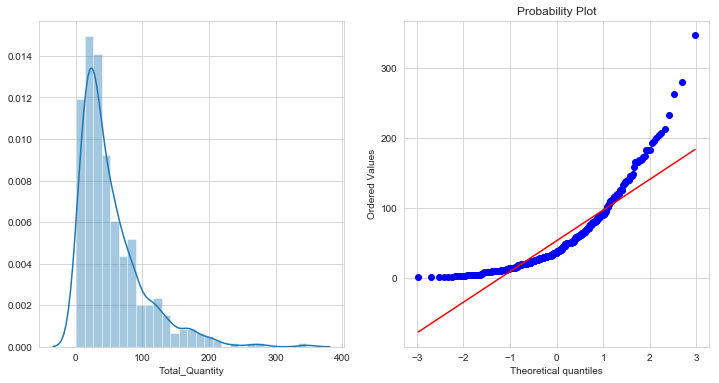

Normality Check for 0.15: 
    Kolmogorov-Smirnov: 0.020357405649398252
    Shapiro-Wilks: 3.5982549206892145e-07
Variance: 3338.825789473685


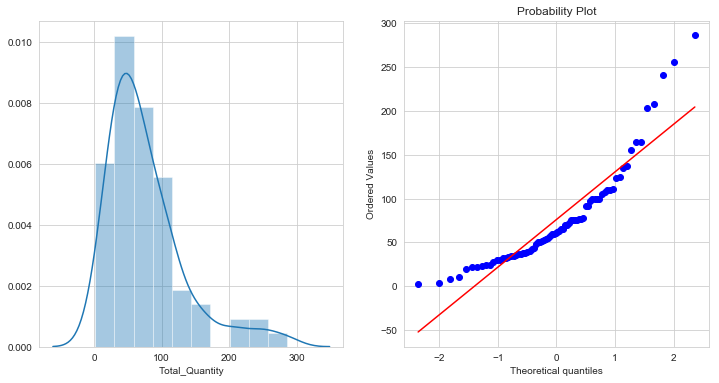

Normality Check for 0.05: 
    Kolmogorov-Smirnov: 0.007497994994779988
    Shapiro-Wilks: 2.767040996332071e-07
Variance: 2151.981366459627


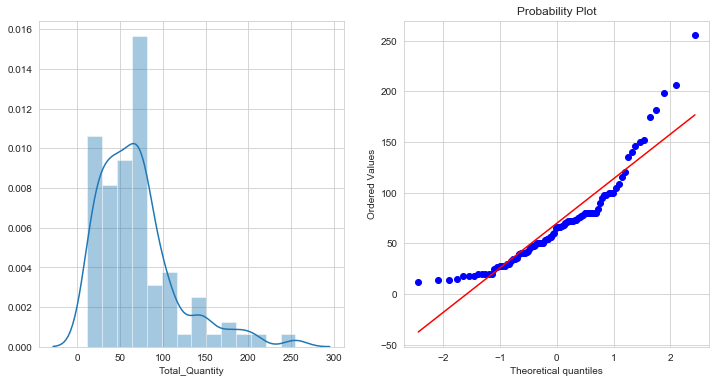

Normality Check for 0.2: 
    Kolmogorov-Smirnov: 0.19599241323998462
    Shapiro-Wilks: 4.094493851880543e-05
Variance: 2598.2894736842104


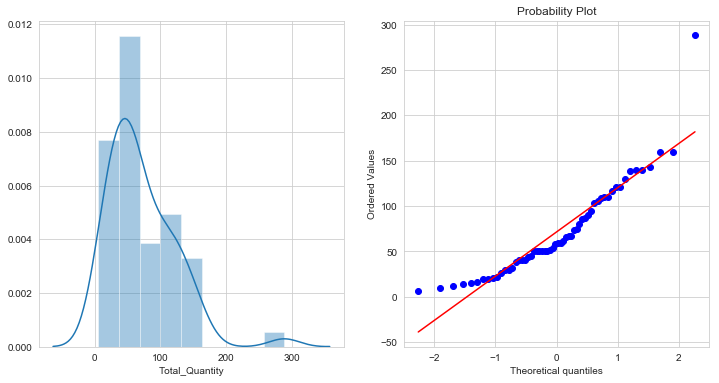

Normality Check for 0.25: 
    Kolmogorov-Smirnov: 0.3072312469489962
    Shapiro-Wilks: 7.018655742285773e-05
Variance: 3835.0377073906493


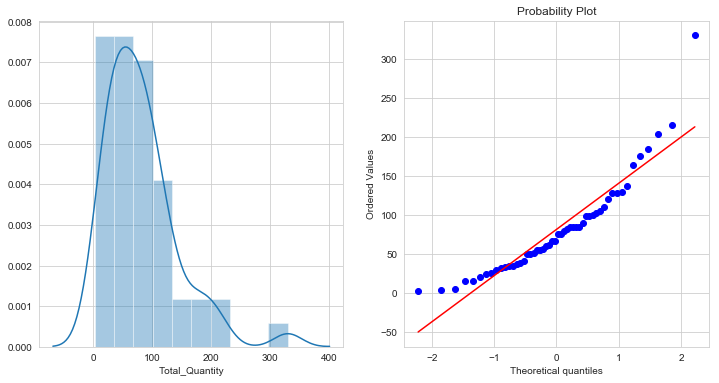

Normality Check for 0.1: 
    Kolmogorov-Smirnov: 0.15971162140496697
    Shapiro-Wilks: 2.584132232641423e-07
Variance: 2136.746511627907


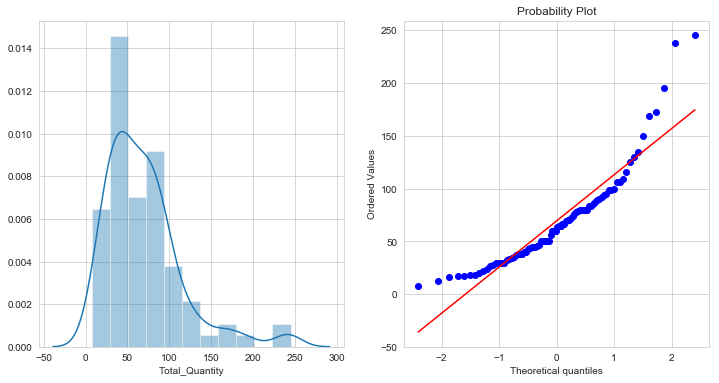

In [52]:
for discount in order_discount.Discount_Median.unique():
    sample = order_discount.loc[order_discount.Discount_Median == discount]
    norm_check(sample.Total_Quantity, discount)


In [227]:
# Create a list of all the possible combinations of discount levels and check for equal variance between them

discount_combos = list(itertools.combinations(order_discount.Discount_Median.unique(), 2))

columns = ['Discount_Level1', 'Discount_Level2', 'P_value', 'Result']
variance_check_multiple(discount_combos, order_discount, 'Discount_Median', 'Total_Quantity', 'no', columns)

,Discount_Level1,Discount_Level2,P_value,Result
0,0.00,0.15,0.030266,UNEQUAL variance
1,0.00,0.05,0.654141,EQUAL variance
2,0.00,0.20,0.557232,EQUAL variance
3,0.00,0.25,0.009926,UNEQUAL variance
4,0.00,0.10,0.633396,EQUAL variance
5,0.15,0.05,0.046426,UNEQUAL variance
6,0.15,0.20,0.318159,EQUAL variance
7,0.15,0.25,0.589366,EQUAL variance
8,0.15,0.10,0.046928,UNEQUAL variance
9,0.05,0.20,0.428806,EQUAL variance


## b. Statistical Tests:

Since no distribution is normal based on the Shapiro-Wilks test and because there is inconsistency in variance equality between the subsets of discount levels, hypothesis testing will be conducted under the assumption that the data is non-parametric.

The null hypothesis for the following test is that the discounted orders do not differ from the non-discounted orders in terms of order quantity.

The alternative hypothesis for the following test is that the discounted orders do differ from the non-discounted orders in terms of order quantity.

This is a two-tailed test to establish a significant difference between the two samples and the alpha value is 0.05.

In [228]:
# Orders containing a discount vs orders not containing a discount

no_discount = order_discount.loc[order_discount.Discount_Median == 0]
yes_discount = order_discount.loc[order_discount.Discount_Median > 0]

values = []

np_results = non_parametric(no_discount.Total_Quantity, yes_discount.Total_Quantity)

values.append((np_results[0][0], np_results[0][1], np_results[0][2], np_results[0][3], np_results[0][4], np_results[0][5]))

pd.DataFrame(values, columns=['Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal-Wallis_p', 'Effect_Size', 
                              'Post_Hoc', 'Result'])

,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal-Wallis_p,Effect_Size,Post_Hoc,Result
0,3.203918e-12,2.416903e-13,4.828616e-13,-0.396763,2.416903e-13,Significantly SMALLER


In [50]:
mann_whit_greater(yes_discount.Total_Quantity, no_discount.Total_Quantity)

2.416903120747266e-13

### Initial Analysis:### 
The results above demonstrate that there is a statistical difference in the total quantity of the orders containing discounts from the orders not containing discounts as all three p-values are below 0.05. Thus, the null hypothesis is rejected and further analysis of how these two samples differ is needed. The effect size (as calculated by Cohen's d) is small to moderate as indicated by the value in the last column. Cohen's d uses the absolute value of the difference between the means of the two samples, thus only the magnitude of the value is used to interprete the size of the difference between the two samples. The directionality of the value is maintained in this project to help guide post-hoc analysis of the differences.

Because the effect size for the difference between the non-discounted and discounted orders was negative, it can be assumed that the mean order quantity of the discounted orders is larger than the mean order quantity of the non-discounted orders. A subsequent Mann-Whitney U test was used to determine if the total order quantity for discounted orders was significantly greater than the total order quantity for non-discounted orders. This is a one-tailed test as it is examining whether the discounted orders are significantly larger than the non-discounted orders. The null hypothesis is that the discounted orders are not significantly larger than the non-discounted orders and the alternative hypothesis is that the discounted orders are significantly larger than the non-discounted orders. The alpha is still 0.05.

### Post-Hoc Testing:###
To determine if there is a significant difference between the different levels of discounts in terms of the total quantity of an order, pairwise compairisons between every combination will be performed using the same non-parametric tests.

The null hypothesis for each of the following tests is that the discount level in the first column does not differ from the discount level in the second column in terms of total quantity of an order.

The alternative hypothesis for each of the following tests is that the discount level in the first column differs from the discount level of the second column in terms of total order quantity.

These tests are two-tailed tests as they are being used to demonstrate a significant difference between the discount levels and the alpha value is 0.05.

In [76]:
columns = ['Discount_Level1', 'Discount_Level2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal-Wallis_p', 
           'Effect_Size', 'Post_Hoc', 'Result']
stats_output(discount_combos, order_discount, 'Discount_Median', 'Total_Quantity', columns)



,Discount_Level1,Discount_Level2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal-Wallis_p,Effect_Size,Post_Hoc,Result
0,0.00,0.15,0.000213,0.000012,0.000024,-0.462981,1.2112e-05,Significantly SMALLER
1,0.00,0.05,0.000036,0.000010,0.000019,-0.343388,9.54312e-06,Significantly SMALLER
2,0.00,0.20,0.001081,0.000459,0.000917,-0.378586,0.000459315,Significantly SMALLER
3,0.00,0.25,0.000745,0.000041,0.000082,-0.569677,4.13254e-05,Significantly SMALLER
4,0.00,0.10,0.000045,0.000011,0.000023,-0.341151,1.13718e-05,Significantly SMALLER
5,0.15,0.05,0.794672,0.354605,0.708024,--,--,--
6,0.15,0.20,0.945596,0.394643,0.787558,--,--,--
7,0.15,0.25,0.495825,0.284291,0.566938,--,--,--
8,0.15,0.10,0.649618,0.361620,0.721983,--,--,--
9,0.05,0.20,0.619022,0.473835,0.946133,--,--,--


In [51]:
levels = []
for level in order_discount.Discount_Median.unique():
    group = order_discount.loc[order_discount.Discount_Median == level]
    
    p = mann_whit_greater(group.Total_Quantity, no_discount.Total_Quantity)
    
    if p < 0.05:
        d = cohen_d(group.Total_Quantity, no_discount.Total_Quantity)
        r = 'SIGNIFICANTLY LARGER'
    else:
        d = '--'
        r = 'not significantly larger'
    levels.append([level, p, d, r])
    
pd.DataFrame(levels, columns=['Discount', 'P_Value', 'Effect_Size', 'Result'])

,Discount,P_Value,Effect_Size,Result
0,0.00,0.500049,--,not significantly larger
1,0.15,0.000012,0.462981,SIGNIFICANTLY LARGER
2,0.05,0.000010,0.343388,SIGNIFICANTLY LARGER
3,0.20,0.000459,0.378586,SIGNIFICANTLY LARGER
4,0.25,0.000041,0.569677,SIGNIFICANTLY LARGER
5,0.10,0.000011,0.341151,SIGNIFICANTLY LARGER


### Post-Hoc Analysis:
The pairwise comparison between the different discount levels indicated that all levels of discounts significantly differ from non-discounted orders in terms of total order quantity. Additionally, the total order quantities of each level of discount is significantly larger than the total order quantity of non-discounted orders. Most importantly, the different discount levels did not differ from each other, indicating that a 25% discount is not significanlty different from a 5% discount in terms of order quantity. However, the effect size for the 25% discount was largest, suggesting that this level of discount had the greatest effect on total order quantity amoung the discount levels.

## 1a. Does a discount affect the total price of an order?

While it is reasonable to assume that an order containing a larger number of items would cost more than an order containing fewer items, it may not be true as an order could contain a high volumn of lower priced items. The previous analysis will be performed to evaluate the affect of discounts on the total price of an order.

**The normality and variance check performed below for the distributions of total order price for the various discount levels below has been commented out in the interest of space and ease of navigation through the notebook. A summary of the finding is included below, but the cells may be uncommented to run the tests if necessary**

In [54]:
# for discount in order_discount.Discount_Median.unique():
#     sample = order_discount.loc[order_discount.Discount_Median == discount]
#     norm_check(sample.Order_Total, discount)

In [56]:
# columns = ['Discount_Level1', 'Discount_Level2', 'P_value', 'Result']
# variance_check_multiple(discount_combos, order_discount, 'Discount_Median', 'Order_Total', 'no', columns)

**a. Normality and Variance:** Similar to what was found for the distributions of order quantities, no distribution of order price was found to be normal by the Shapiro-Wilks test and there is inconsistency in the variances between the groups of discount levels. For these reasons, it will be assumed that the data is non-parametric and the appropriate non-parametric tests will be used to evaluate the effects of discounts on the total price of an order.

**b. Statistical Tests:**
The null hypothesis for the following test is that the discounted orders do not differ from the non-discounted orders in terms of order price.

The alternative hypothesis for the following test is that the discounted orders do differ from the non-discounted orders in terms of order price.

This is a two-tailed test to establish a significant difference between the two samples and the alpha value is 0.05.

In [77]:
values = []

np_results = non_parametric(no_discount.Order_Total, yes_discount.Order_Total)

values.append((np_results[0][0], np_results[0][1], np_results[0][2], np_results[0][3], np_results[0][4], 
               np_results[0][5]))

pd.DataFrame(values, columns=['Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal-Wallis_p', 'Effect_Size', 
                              'Post_hoc', 'Result'])

,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal-Wallis_p,Effect_Size,Post_hoc,Result
0,0.00007,0.000005,0.00001,-0.169422,0.000005,Significantly SMALLER


In [58]:
mann_whit_greater(yes_discount.Order_Total, no_discount.Order_Total)

4.946464270667659e-06

**Initial Analysis:**
The results of the initial test indicate that there is a statistically significant difference between the discounted orders and the non-discounted orders in term of price as all three p-values are below 0.05. Thus, the null hypothesis is rejected and a subsequent Mann-Whitney U test was performed to determine if the total price of the discounted orders is significantly larger than the total price of the non-discounted orders. Again, the p-value was below 0.05 and the null hypothesis was rejected. The effect size for this test is smaller than the effect size during the evaluation of order quantity, indicating that discounts affect order quantity moreso than they affect order price.

**Post-Hoc Testing:**
To determine if there is a significant difference between the different levels of discounts in terms of the total price of an order, pairwise compairisons between every combination will be performed using the same non-parametric tests.

The null hypothesis for each of the following tests is that the discount level in the first column does not differ from the discount level in the second column in terms of total order price.

The alternative hypothesis for each of the following tests is that the discount level in the first column differs from the discount level of the second column in terms of total order price.

These tests are two-tailed tests as they are being used to demonstrate a significant difference between the discount levels and the alpha value is 0.05.

In [78]:
columns = ['Discount_Level1', 'Discount_Level2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal-Wallis_p', 
           'Effect_Size', 'Post_Hoc', 'Result']
stats_output(discount_combos, order_discount, 'Discount_Median', 'Order_Total', columns)


,Discount_Level1,Discount_Level2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal-Wallis_p,Effect_Size,Post_Hoc,Result
0,0.00,0.15,0.022751,0.003529,0.007050,-0.226506,0.00352925,Significantly SMALLER
1,0.00,0.05,0.001580,0.000042,0.000083,-0.305114,4.16499e-05,Significantly SMALLER
2,0.00,0.20,0.203370,0.138421,0.276639,--,--,--
3,0.00,0.25,0.054864,0.020453,0.040858,-0.276416,0.0204533,Significantly SMALLER
4,0.00,0.10,0.047564,0.016469,0.032907,0.0192455,0.983561,not significant
5,0.15,0.05,0.589195,0.202329,0.403759,--,--,--
6,0.15,0.20,0.198783,0.170547,0.339956,--,--,--
7,0.15,0.25,0.886796,0.443097,0.884278,--,--,--
8,0.15,0.10,0.926722,0.282450,0.563766,--,--,--
9,0.05,0.20,0.237638,0.031027,0.061784,0.229684,0.0310267,Significantly LARGER


In [60]:
levels = []
for level in order_discount.Discount_Median.unique():
    group = order_discount.loc[order_discount.Discount_Median == level]
    
    p = mann_whit_greater(group.Order_Total, no_discount.Order_Total)
    
    if p < 0.05:
        d = cohen_d(group.Order_Total, no_discount.Order_Total)
        r = 'SIGNIFICANTLY LARGER'
    else:
        d = '--'
        r = 'not significantly larger'
    levels.append([level, p, d, r])
    
pd.DataFrame(levels, columns=['Discount', 'P_Value', 'Effect_Size', 'Result'])

,Discount,P_Value,Effect_Size,Result
0,0.00,0.500049,--,not significantly larger
1,0.15,0.003529,0.226506,SIGNIFICANTLY LARGER
2,0.05,0.000042,0.305114,SIGNIFICANTLY LARGER
3,0.20,0.138421,--,not significantly larger
4,0.25,0.020453,0.276416,SIGNIFICANTLY LARGER
5,0.10,0.016469,-0.0192455,SIGNIFICANTLY LARGER


**Post-Hoc Analysis:**
The pairwise comparison between the different discount levels indicates that all levels of discounts significantly differ from non-discounted orders in terms of total order price except for the 20% discount. Additionally, the total order price of each level of discount (again, except for 20%) is significantly larger than the total order price of non-discounted orders. Most importantly, there is no statistical difference between the discount levels that significantly differed from non-discounted orders. Thus, the total price of an order with a 5% discount is not significantly different from the total price of an order with a 25% discount. However, the effect size of the 5% discount is the largest, suggesting that this level of discount affects the total price of the order more than the other discount levels.


# Conclusion: Discounts

Discounts significantly affect both the order quantity and order price, but affect order quantity moreso than order price. All discount levels significantly increase order quantity from non-discounted orders, where 25% discounts result in the strongest effect on order quantity. All discounts except for 20% discounts significantly increase order price from non-discounted orders, where 5% discounts result in the strongest effect on order price. Based on this evaluation, it is suggested that discounts of 25% be offered on orders if the directive of the discount is to encourage the customer to purchase more items and to offer 5% discounts if the directive of the discount is to encourage the customer to spend more money on an order.

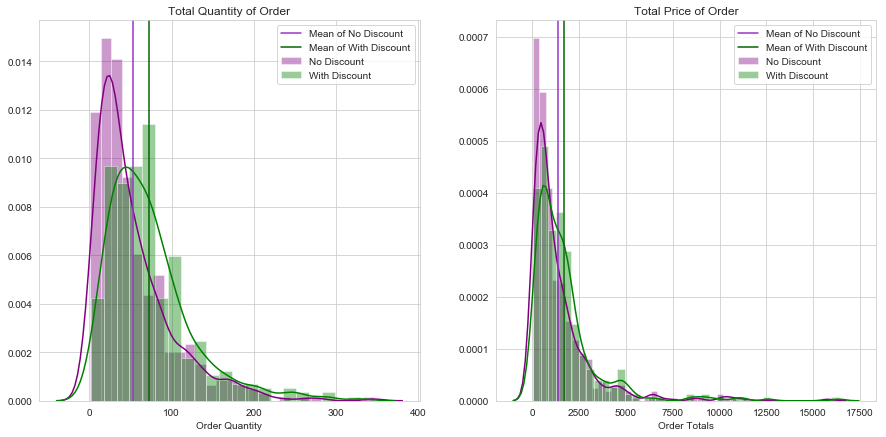

In [63]:
fig, axes = plt.subplots(1,2, figsize=[15,7])

sns.distplot(no_discount.Total_Quantity, color='purple', label='No Discount', ax=axes[0])
axes[0].axvline(x=no_discount.Total_Quantity.mean(), color='darkorchid', label='Mean of No Discount')
sns.distplot(yes_discount.Total_Quantity, color='green', label='With Discount', ax=axes[0])
axes[0].axvline(x=yes_discount.Total_Quantity.mean(), color='darkgreen', label='Mean of With Discount')
axes[0].legend()
axes[0].set_title('Total Quantity of Order')
axes[0].set_xlabel('Order Quantity')

sns.distplot(no_discount.Order_Total, color='purple', label='No Discount', ax=axes[1])
axes[1].axvline(x=no_discount.Order_Total.mean(), color='darkorchid', label='Mean of No Discount')
sns.distplot(yes_discount.Order_Total, color='green', label='With Discount', ax=axes[1])
axes[1].axvline(x=yes_discount.Order_Total.mean(), color='darkgreen', label='Mean of With Discount')
axes[1].set_title('Total Price of Order')
axes[1].set_xlabel('Order Totals')
axes[1].legend()
plt.show()

# 2. Is there a difference between shipping companies?


In [19]:
orders = make_df('[Order]', cols=None)
orders.head()

2019-04-05 08:50:28,286 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-05 08:50:28,287 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


source: https://towardsdatascience.com/hypothesis-testing-in-the-northwind-dataset-using-anova-db3ab16b5eba

In [20]:
# Group Scandinavia with Northern Europe, Eastern Europe with Southern Europe, and Central America with South America
# to help equalize the sample sizes between the regions for testing

orders_region_grouped = orders.copy()

orders_region_grouped.loc[(orders_region_grouped.ShipRegion == 'Northern Europe') | 
                          (orders_region_grouped.ShipRegion == 'Scandinavia'),
                          'ShipRegion'] = 'Northern Europe/Scandinavia'
orders_region_grouped.loc[(orders_region_grouped.ShipRegion == 'Eastern Europe') | 
                          (orders_region_grouped.ShipRegion == 'Southern Europe'), 
                          'ShipRegion'] = 'Eastern/Southern Europe'
orders_region_grouped.loc[(orders_region_grouped.ShipRegion == 'Central America') | 
                          (orders_region_grouped.ShipRegion == 'South America'), 
                          'ShipRegion'] = 'Central/South America'

orders_region_grouped.ShipRegion.value_counts()



Western Europe                 276
Central/South America          173
North America                  152
Northern Europe/Scandinavia     83
British Isles                   75
Eastern/Southern Europe         71
Name: ShipRegion, dtype: int64

## a. Normality and Variance Check

In [68]:
# for shipper in orders_region_grouped.ShipVia.unique():
#     group = orders_region_grouped.loc[orders_region_grouped.ShipVia == shipper]
#     if shipper == 1:
#         name = 'Speedy Express'
#     elif shipper == 2:
#         name = 'United Package'
#     else:
#         name = 'Federal Shipper'
#     norm_check(group.Freight, name)

In [28]:
ship_combos = list(itertools.combinations(orders_region_grouped.ShipVia.unique(), 2))

In [21]:

columns = ['ShipCompany1', 'ShipCompany2', 'Variance_Test_p', 'Result']
variance_check_multiple(ship_combos, orders_region_grouped, 'ShipVia', 'Freight', 'no', columns)

,ShipCompany1,ShipCompany2,Variance_Test_p,Result
0,3,1,9.565535e-13,UNEQUAL variance
1,3,2,1.406535e-02,UNEQUAL variance
2,1,2,5.840075e-22,UNEQUAL variance


## b. Statistical Testing
Since the distribution of shipping cost (freight) is not normal according to the Shapiro-Wilks test for any of the three shipping companies and because their is unequal variance between the distributions, hypothesis testing will be conducted under the assumption that the data is non-parametric when evaluating the difference between the shipping companies in terms of shipping cost.

The null hypothesis is that there is no difference between the shipping companies in terms of shipping cost.

The alternative hypothesis is that there is a difference in terms of shipping cost between the three shipping companies.

This is a two-tailed test to determine is a difference exists between the shipping companies and the alpha value is 0.05.

In [79]:
columns = ['Company1', 'Company2', 'Kolmogorov_Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size', 
           'Post_Hoc', 'Result']
stats_output(ship_combos, orders_region_grouped, 'ShipVia', 'Freight', columns)

,Company1,Company2,Kolmogorov_Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,3,1,0.766395,0.360333,0.720437,--,--,--
1,3,2,0.910420,0.379789,0.759388,--,--,--
2,1,2,0.697865,0.232999,0.465842,--,--,--


**Analysis:** The results of the statistical test suggest there is no significant difference between the three shipping companies in terms of shipping cost as all p-values are greater than 0.05. Therefore, the null hypothesis can not be rejected.

This test evaluated each shipping company for all of the orders they handled. To further investigate the differences between the shipping companies, this process will be repeated to evaluate the shipping cost for each geographical region.

## 2a. Do the freight costs differ per region for each shipping company?

In [23]:
# Create dataframe representing the subset of orders handled by each company

ship1 = orders_region_grouped.loc[orders_region_grouped.ShipVia == 1]
print(ship1.shape)
ship2 = orders_region_grouped.loc[orders_region_grouped.ShipVia == 2]
print(ship2.shape)
ship3 = orders_region_grouped.loc[orders_region_grouped.ShipVia == 3]
print(ship3.shape)

(249, 14)
(326, 14)
(255, 14)


In [36]:
# Check normality of the distribution of shipping costs per region for Speedy Express

# for region in ship1.ShipRegion.unique():
#     reg = ship1.loc[ship1.ShipRegion == region]
#     norm_check(reg.Freight, region)

In [38]:
# Check normality of the distribution of shipping costs per region for United Package

# for region in ship2.ShipRegion.unique():
#     reg = ship2.loc[ship2.ShipRegion == region]
#     norm_check(reg.Freight, region)


In [40]:
# Check normality of the distribution of shipping costs per region for Federal Shipper

# for region in ship3.ShipRegion.unique():
#     reg = ship3.loc[ship3.ShipRegion == region]
#     norm_check(reg.Freight, region)

In [24]:
region_combos = list(itertools.combinations(ship1.ShipRegion.unique(), 2))

In [30]:
# Check for equal variance between the regions for Speedy Express

# columns = ['Region1', 'Region2', 'Variance_Test_p', 'Result']
# variance_check_multiple(region_combos, ship1, 'ShipRegion', 'Freight', 'no', columns)


In [32]:
# Check for equal variance between the regions for United Package

# columns = ['Region1', 'Region2', 'Variance_Test_p', 'Result']
# variance_check_multiple(region_combos, ship2, 'ShipRegion', 'Freight', 'no', columns)


In [34]:
# Check for eaqual variance between the regions for Federal Package

# columns = ['Region1', 'Region2', 'Variance_Test_p', 'Result']
# variance_check_multiple(region_combos, ship3, 'ShipRegion', 'Freight', 'no', columns)

**Normality and Variance:** Only one of the region distributions for the three companies was identified as normal and 31 out of 45 region combinations (15 for each company) had unequal variances. Due to these findings, hypothesis testing will be conducted under the assumption that this data is non-parametric.

**Statistical Testing:** Pairwise comparisons of the shipping costs for the orders in each region will be performed for each shipping company.

The null hypothesis for each comparison is that there is no difference between the shipping costs per region.

The alternative hypothesis for each comparison is that there is a difference between the shipping costs per region.

These are two-tailed tests as they are determining if there is a difference, rather than directionailty of a difference. The alpha value is 0.05.

In [85]:
# Test for differences in shipping cost between regions for Speedy Express

columns = ['Region1', 'Region2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
regions1 = stats_output(region_combos, ship1, 'ShipRegion', 'Freight', columns)

# Drop combinations that did not reach significance
regions1.replace({'--': np.nan}, inplace=True)
regions1.dropna(inplace=True)
regions1

,Region1,Region2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
1,Western Europe,Northern Europe/Scandinavia,0.135320,0.037111,0.073707,0.325620,0.037111,Significantly LARGER
2,Western Europe,Eastern/Southern Europe,0.001830,0.000096,0.000190,0.690486,0.000096,Significantly LARGER
3,Western Europe,Central/South America,0.059266,0.008522,0.016951,0.497967,0.008522,Significantly LARGER
6,North America,Eastern/Southern Europe,0.032194,0.001151,0.002248,0.807371,0.001151,Significantly LARGER
12,Eastern/Southern Europe,Central/South America,0.055364,0.016362,0.032326,-0.446181,0.016362,Significantly SMALLER
13,Eastern/Southern Europe,British Isles,0.021740,0.008299,0.015995,-0.875852,0.008299,Significantly SMALLER


**Analysis for Speedy Express:** The statistical results suggest that orders going to Western Europe have the highest shipping cost as this region's freight costs are significantly larger than the freight costs of three of the five other regions. Additionally, the results suggest that orders going to the Eastern/Southern Europe region have the lowest shipping costs as their freight costs are significantly lower than two of the other five regions and logically lower than two other regions.

In [81]:
# Test for differences in shipping cost between regions for United Package

columns = ['Region1', 'Region2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
regions2 = stats_output(region_combos, ship2, 'ShipRegion', 'Freight', columns)

# Drop combinations that did not reach significance
regions2.replace({'--': np.nan}, inplace=True)
regions2.dropna(inplace=True)
regions2

,Region1,Region2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
1,Western Europe,Northern Europe/Scandinavia,0.045161,0.034827,0.069266,-0.139343,0.034827,Significantly SMALLER
9,Northern Europe/Scandinavia,Eastern/Southern Europe,0.074968,0.028868,0.056532,0.678072,0.028868,Significantly LARGER
10,Northern Europe/Scandinavia,Central/South America,0.013092,0.012486,0.024718,0.319365,0.012486,Significantly LARGER


**Analysis for United Package:** Based on the statistical results, there is less variation in shipping costs between the different regions for United Package as only three region combinations acheived significance. Orders going to Northern Europe/Scandinavia appear to have the higest shipping costs as it is statistically larger than two other regions and logically larger than a third region.

In [82]:
# Test for differences in shipping cost between regions for Federal Shipper

columns = ['Region1', 'Region2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
regions3 = stats_output(region_combos, ship3, 'ShipRegion', 'Freight', columns)

# Drop combinations that did not reach significance
regions3.replace({'--': np.nan}, inplace=True)
regions3.dropna(inplace=True)
regions3

,Region1,Region2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
1,Western Europe,Northern Europe/Scandinavia,0.027325,0.006521,0.012898,0.479495,0.006521,Significantly LARGER
2,Western Europe,Eastern/Southern Europe,0.003280,0.000183,0.000360,0.611474,0.000183,Significantly LARGER
3,Western Europe,Central/South America,0.002812,0.000416,0.000824,0.563215,0.000416,Significantly LARGER
4,Western Europe,British Isles,0.071795,0.020994,0.041620,0.409868,0.020994,Significantly LARGER
5,North America,Northern Europe/Scandinavia,0.037944,0.020187,0.039877,0.536532,0.020187,Significantly LARGER
6,North America,Eastern/Southern Europe,0.006480,0.001195,0.002347,0.673981,0.001195,Significantly LARGER
7,North America,Central/South America,0.011809,0.002765,0.005474,0.639351,0.002765,Significantly LARGER
13,Eastern/Southern Europe,British Isles,0.356262,0.047359,0.092804,-0.485873,0.047359,Significantly SMALLER


**Analysis for Federal Shipper:** The statistical results suggest that orders going to Western Europe incure the highest shipping costs as this region's freight costs are significantly larger than four of the other five regions. Similarly, shipping costs going to North America are significantly larger than the shipping costs to three of the other five regions. The average effect size for significant North American orders (0.62) is larger than the average effect size for Western European orders (0.52), suggesting North American orders has a larger effect on shipping costs than Western European orders.

## 2b. Is there a difference in shipping speed between the three companies?

In [86]:
orders_region_grouped.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,Central/South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [87]:
# Remove null values
orders_region_grouped.ShippedDate.isna().sum()
ord_reg_grp = orders_region_grouped.copy()
ord_reg_grp.dropna(inplace=True)
ord_reg_grp.isna().sum()

Id                0
CustomerId        0
EmployeeId        0
OrderDate         0
RequiredDate      0
ShippedDate       0
ShipVia           0
Freight           0
ShipName          0
ShipAddress       0
ShipCity          0
ShipRegion        0
ShipPostalCode    0
ShipCountry       0
dtype: int64

In [88]:
# Convert OrderDate, RequiredDate, and ShippedDate to datetime and create a column representing how many days passed
# between the order date and the shipped date. Also create a column that represents the difference in days between
# the required date and the shipped date, where negative values indicate how many days a shipment left before the 
# required date and a positive value indicates how many days a shipment left after the required date

ord_reg_grp.OrderDate = pd.to_datetime(ord_reg_grp.OrderDate)
ord_reg_grp.ShippedDate = pd.to_datetime(ord_reg_grp.ShippedDate)

time_to_Ship = ord_reg_grp.ShippedDate - ord_reg_grp.OrderDate
ord_reg_grp['Order_Processing'] = (time_to_Ship / np.timedelta64(1, 'D')).astype(int)

ord_reg_grp.RequiredDate = pd.to_datetime(ord_reg_grp.RequiredDate)
required_time = ord_reg_grp.ShippedDate - ord_reg_grp.RequiredDate
ord_reg_grp['Promised_Time'] = (required_time / np.timedelta64(1, 'D')).astype(int)

ord_reg_grp.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Order_Processing,Promised_Time
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,12,-16
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,5,-37
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,Central/South America,05454-876,Brazil,4,-24
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,7,-21
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2,-26


In [90]:
# Normality check for order processsing times for the three shipping companies. Commented out to save space

# for shipper in ord_reg_grp.ShipVia.unique():
#     sample = ord_reg_grp.loc[ord_reg_grp.ShipVia == shipper]
#     if shipper == 1:
#         name = 'Speedy Express'
#     elif shipper == 2:
#         name = 'United Package'
#     else:
#         name = 'Federal Shipper'
#     norm_check(sample.Order_Processing, name)


In [92]:
# columns = ['ShipCompany1', 'ShipCompany2', 'Variance_Test_p', 'Result']
# variance_check_multiple(ship_combos, ord_reg_grp, 'ShipVia', 'Order_Processing', 'no', columns)

In [93]:
process_combos = list(itertools.combinations(ord_reg_grp.ShipVia.unique(), 2))

In [94]:
columns = ['Company1', 'Company2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(process_combos, ord_reg_grp, 'ShipVia', 'Order_Processing', columns)

,Company1,Company2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,3,1,0.291743,0.040752,0.081446,-0.1812,0.0407518,Significantly SMALLER
1,3,2,0.125530,0.011376,0.022736,-0.267892,0.0113762,Significantly SMALLER
2,1,2,0.959026,0.295044,0.589898,--,--,--


**Analysis:** The statistical results suggest that Federal Shipper is the fastest shipping company of the three as its order processing time is significantly smaller than the other two companies. Additionally, there is no statistical difference between the other two shipping companies.

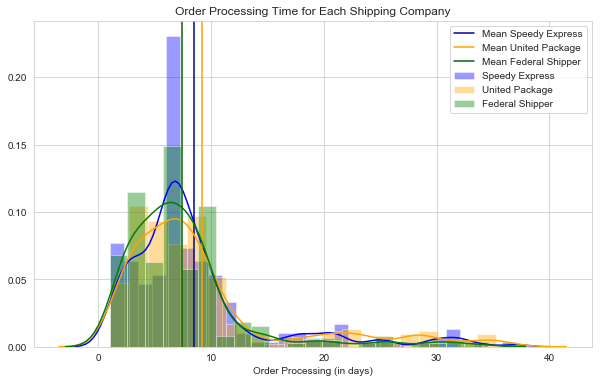

In [97]:
processing1 = ord_reg_grp.loc[ord_reg_grp.ShipVia == 1]
processing2 = ord_reg_grp.loc[ord_reg_grp.ShipVia == 2]
processing3 = ord_reg_grp.loc[ord_reg_grp.ShipVia == 3]

fig = plt.figure(figsize=[10,6])

sns.distplot(processing1.Order_Processing, color='blue', label='Speedy Express')
plt.axvline(processing1.Order_Processing.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(processing2.Order_Processing, color='orange', label='United Package')
plt.axvline(processing2.Order_Processing.mean(), color='orange', label='Mean United Package')
sns.distplot(processing3.Order_Processing, color='green', label='Federal Shipper')
plt.axvline(processing3.Order_Processing.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.title('Order Processing Time for Each Shipping Company')
plt.xlabel('Order Processing (in days)')
plt.show()

## 2c. Does the size of the order affect how long it takes to ship it?

In [98]:
order_size_main = join_2('[Order] o', 'OrderDetail d', '''d.OrderId, d.UnitPrice, d.Quantity, d.Discount, 
o.OrderDate, o.ShippedDate, o.ShipVia, o.ShipRegion''', 'o.Id=d.OrderId')
order_size_main.head()

2019-04-05 12:15:28,332 INFO sqlalchemy.engine.base.Engine SELECT d.OrderId, d.UnitPrice, d.Quantity, d.Discount, 
o.OrderDate, o.ShippedDate, o.ShipVia, o.ShipRegion FROM [Order] o JOIN OrderDetail d on o.Id=d.OrderId
2019-04-05 12:15:28,333 INFO sqlalchemy.engine.base.Engine ()


,OrderId,UnitPrice,Quantity,Discount,OrderDate,ShippedDate,ShipVia,ShipRegion
0,10248,14.0,12,0.0,2012-07-04,2012-07-16,3,Western Europe
1,10248,9.8,10,0.0,2012-07-04,2012-07-16,3,Western Europe
2,10248,34.8,5,0.0,2012-07-04,2012-07-16,3,Western Europe
3,10249,18.6,9,0.0,2012-07-05,2012-07-10,1,Western Europe
4,10249,42.4,40,0.0,2012-07-05,2012-07-10,1,Western Europe


In [99]:
order_size_main.dropna(inplace=True)
order_size_main.OrderDate = pd.to_datetime(order_size_main.OrderDate)
order_size_main.ShippedDate = pd.to_datetime(order_size_main.ShippedDate)
times =  order_size_main.ShippedDate - order_size_main.OrderDate
order_size_main['Order_Processing'] = (times / np.timedelta64(1, 'D')).astype(int)
order_size_main.head()

,OrderId,UnitPrice,Quantity,Discount,OrderDate,ShippedDate,ShipVia,ShipRegion,Order_Processing
0,10248,14.0,12,0.0,2012-07-04,2012-07-16,3,Western Europe,12
1,10248,9.8,10,0.0,2012-07-04,2012-07-16,3,Western Europe,12
2,10248,34.8,5,0.0,2012-07-04,2012-07-16,3,Western Europe,12
3,10249,18.6,9,0.0,2012-07-05,2012-07-10,1,Western Europe,5
4,10249,42.4,40,0.0,2012-07-05,2012-07-10,1,Western Europe,5


In [101]:
# Group the shipments by OrderId and sum the quantity for each order. Convert the data into a dataframe containing
# the OrderId, Shipping company, Processing Time, and Total Quantity

totals = []
for order in order_size_main.OrderId.unique():
    temp = order_size_main.loc[order_size_main.OrderId == order]
    tot = sum(temp.Quantity)
    pro = temp.Order_Processing.mean()
    ship = temp.ShipVia.mean()
    totals.append([order, ship, pro, tot])

order_size = pd.DataFrame(totals, columns=['Order', 'ShipComp', 'ProcessingTime', 'Total_Quantity'])
order_size.head()

,Order,ShipComp,ProcessingTime,Total_Quantity
0,10248,3.0,12.0,27
1,10249,1.0,5.0,49
2,10250,2.0,4.0,60
3,10251,1.0,7.0,41
4,10252,2.0,2.0,105


In [103]:
# Create a new column classifying the order quantities into small (0-30 items), medium (31-75 items), and large
# (greater than 75 items)

sizes = []

for val in order_size.Total_Quantity:
    if val <= 30:
        c = 'Small'
    elif val >= 31 and val <=75:
        c = 'Medium'
    else:
        c = 'Large'
    sizes.append(c)

order_size['Order_Size'] = sizes
order_size.Order_Size.value_counts()

Medium    314
Small     252
Large     243
Name: Order_Size, dtype: int64

In [104]:
size_combos = list(itertools.combinations(order_size.Order_Size.unique(), 2))

In [106]:
# for size in order_size.Order_Size.unique():
#     group = order_size.loc[order_size.Order_Size == size]
#     norm_check(group.ProcessingTime, size)

In [136]:
# columns = ['Size_class1', 'Size_class2', 'Variance_Test_p', 'Result']
# variance_check_multiple(size_combos, order_size, 'Order_Size', 'ProcessingTime', 'no', columns)

**Normality and Variance Check:** None of the order size distributions in terms of processing time were normal according to the Shapiro-Wilks test and two of the three size combinations had unequal variance. Thus, hypothesis testing will be conducted under the assumption that the data is non-parametric.

**Statistical Testing:** Pairwise comparison of the three different order sizes will be evaluated in terms of order processing time.

The null hypothesis is that there is no difference in the order processing time between order sizes.

The alternative hypothesis is that there is a difference between the order processing time between order sizes.

These tests are two-tailed as they are determining a difference between the order sizes. The alpha value is 0.05.

In [112]:
columns = ['Size_class1', 'Size_class2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(size_combos, order_size, 'Order_Size', 'ProcessingTime', columns)

,Size_class1,Size_class2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,Small,Medium,0.630959,0.218563,0.436972,--,--,--
1,Small,Large,0.077420,0.059275,0.118475,--,--,--
2,Medium,Large,0.863411,0.211040,0.421926,--,--,--


**Analysis:** The tests suggest that there is no difference in terms of processing time between the three order sizes. Follow-up testing will be performed to determine if this trend holds true for the three shipping companies when evaluated separately.

In [132]:
size_speedy = order_size.loc[order_size.ShipComp == 1]
print(size_speedy.Order_Size.value_counts())
size_united = order_size.loc[order_size.ShipComp == 2]
print(size_united.Order_Size.value_counts())
size_federal = order_size.loc[order_size.ShipComp == 3]
print(size_federal.Order_Size.value_counts())

Medium    89
Small     79
Large     77
Name: Order_Size, dtype: int64
Medium    137
Large      90
Small      88
Name: Order_Size, dtype: int64
Medium    88
Small     85
Large     76
Name: Order_Size, dtype: int64


In [ ]:
# for size in size_speedy.Order_Size.unique():
#     group = size_speedy.loc[size_speedy.Order_Size == size]
#     norm_check(group.ProcessingTime, size)

In [ ]:
# for size in size_united.Order_Size.unique():
#     group = size_united.loc[size_united.Order_Size == size]
#     norm_check(group.ProcessingTime, size)

In [ ]:
# for size in size_federal.Order_Size.unique():
#     group = size_federal.loc[size_federal.Order_Size == size]
#     norm_check(group.ProcessingTime, size)

In [134]:
# columns = ['Size_class1', 'Size_class2', 'Variance_Test_p', 'Result']
# variance_check_multiple(size_combos, size_speedy, 'Order_Size', 'ProcessingTime', 'no', columns)

In [ ]:
# columns = ['Size_class1', 'Size_class2', 'Variance_Test_p', 'Result']
# variance_check_multiple(size_combos, size_united, 'Order_Size', 'ProcessingTime', 'no', columns)

In [ ]:
# columns = ['Size_class1', 'Size_class2', 'Variance_Test_p', 'Result']
# variance_check_multiple(size_combos, size_federal, 'Order_Size', 'ProcessingTime', 'no', columns)

**Normality and Variance:** None of the order size distributions were normal according to the Shapiro-Wilks test in terms of processing times. While the variance between the size combinations was found to be equal for United Package and Federal Shipper, only one size combination displayed equal variance for Speedy Express. Because none of the distributions are normal, it will be assumed that the data is non-parametric.

**Statistical Testing:** Pairwise comparisons between the order sizes will be evaluated in terms of processing time for each shipping company.

The null hypothesis for these tests are that there are no differences between the processing times for the order sizes.

The alternative hypothesis is that there is a difference between the processing times for the order sizes.

These tests are two-tailed to establish a statistical difference and the alpha value is 0.05.

In [113]:
columns = ['Size_class1', 'Size_class2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(size_combos, size_speedy, 'Order_Size', 'ProcessingTime', columns)

,Size_class1,Size_class2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,Small,Medium,0.386104,0.13499,0.269287,--,--,--
1,Small,Large,0.044176,0.00919,0.018293,0.355378,0.00919023,Significantly LARGER
2,Medium,Large,0.463360,0.07540,0.150338,--,--,--


In [135]:
size_speedy.groupby('Order_Size')['ProcessingTime'].mean()

Order_Size
Large     7.129870
Medium    9.146067
Small     9.329114
Name: ProcessingTime, dtype: float64

**Analysis Speedy Express:** The tests indicate that the processing time for small packages is significantly larger than the processing time for large packages.

In [114]:
columns = ['Size_class1', 'Size_class2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(size_combos, size_united, 'Order_Size', 'ProcessingTime', columns)

,Size_class1,Size_class2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,Small,Medium,0.921219,0.337227,0.673685,--,--,--
1,Small,Large,0.714763,0.295572,0.590137,--,--,--
2,Medium,Large,0.804061,0.145431,0.290389,--,--,--


**Analysis United Package:** The tests suggest that there is no statistical difference in the processing times for the different package sizes.

In [115]:
columns = ['Size_class1', 'Size_class2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(size_combos, size_federal, 'Order_Size', 'ProcessingTime', columns)

,Size_class1,Size_class2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,Small,Medium,0.141693,0.094107,0.187703,--,--,--
1,Small,Large,0.941499,0.443834,0.886325,--,--,--
2,Medium,Large,0.519305,0.073959,0.147454,--,--,--


**Analysis Federal Shipper:** The tests suggest that there is no statistical difference in the processing times for the different package sizes.

# Conclusion: Shipping

Overall, there is no statistical difference in terms of shipping costs between the three companies. Upon evaluation of the shipping costs by region, United Package returned the fewest significant differences between the regions. Thus, if shipping costs are difficult to predict (and therefore budget appropriately) when using three companies, consider naming United Package your only shipping company as its overall shipping costs do not differ significantly from the other two companies and because its costs do not vary as much by region. 

Testing indicated that Federal Shipper has a significantly lower processing time per order from the other two shipping companies and there is no significant difference in the processing time between small, medium, and large quantity orders. However, of the orders in this sample, Federal Shipper had the highest percentage of its orders shipped after the required date (7.2%) amoung the three companies (Speedy Express: 4.5%; United Package: 4.8%), but its average duration of delay (5.4 days) was the lowest of the three companies (Speedy Express: 8.3 days; United Package: 5.8 days). Thus, if speed of delivery is the primary concern, consider shipping more through Federal Shipper as it was significantly faster than the other two companies and had the shortest duration of delay.

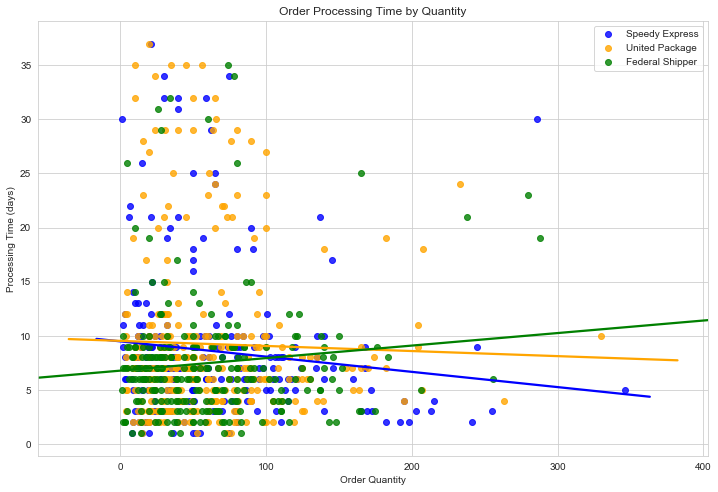

In [150]:
quant_ship1 = order_size.loc[order_size.ShipComp == 1]
quant_ship2 = order_size.loc[order_size.ShipComp == 2]
quant_ship3 = order_size.loc[order_size.ShipComp == 3]

fig = plt.figure(figsize=[12,8])

sns.regplot(x='Total_Quantity', y='ProcessingTime', data=quant_ship1, color='blue', ci=0, label='Speedy Express')
sns.regplot(x='Total_Quantity', y='ProcessingTime', data=quant_ship2, color='orange', ci=0, label='United Package')
sns.regplot(x='Total_Quantity', y='ProcessingTime', data=quant_ship3, color='green', ci=0, label='Federal Shipper')
plt.legend()
plt.title('Order Processing Time by Quantity')
plt.xlabel('Order Quantity')
plt.ylabel('Processing Time (days)')
plt.show()

# 3. Is there a difference in order total between customer contact types?

In [151]:
contacts_main = join_3('Customer c', '[Order] o', 'OrderDetail d', '''c.CompanyName, c.ContactTitle, d.OrderId, 
d.UnitPrice, d.Quantity, d.Discount''', 'c.Id = o.CustomerId', 'd.OrderId = o.Id')
contacts_main.head()

2019-04-05 14:13:32,003 INFO sqlalchemy.engine.base.Engine SELECT c.CompanyName, c.ContactTitle, d.OrderId, 
d.UnitPrice, d.Quantity, d.Discount FROM Customer c JOIN [Order] o on c.Id = o.CustomerId JOIN OrderDetail d on d.OrderId = o.Id
2019-04-05 14:13:32,004 INFO sqlalchemy.engine.base.Engine ()


,CompanyName,ContactTitle,OrderId,UnitPrice,Quantity,Discount
0,Vins et alcools Chevalier,Accounting Manager,10248,14.0,12,0.0
1,Vins et alcools Chevalier,Accounting Manager,10248,9.8,10,0.0
2,Vins et alcools Chevalier,Accounting Manager,10248,34.8,5,0.0
3,Toms Spezialitäten,Marketing Manager,10249,18.6,9,0.0
4,Toms Spezialitäten,Marketing Manager,10249,42.4,40,0.0


In [152]:
# Group the data by OrderId, sum the total order quantity and calculate order price with applied discounts

results = []
for order in contacts_main.OrderId.unique():
    temp = contacts_main.loc[contacts_main.OrderId == order]
    quant = sum(temp.Quantity)
    cost = sum(temp.UnitPrice * temp.Quantity * (1-temp.Discount))
    results.append([order, temp.CompanyName.max(), temp.ContactTitle.max(), quant, cost])

contacts = pd.DataFrame(results, columns=['Order', 'Company', 'Contact', 'Quantity', 'Total'])
contacts.head()

,Order,Company,Contact,Quantity,Total
0,10248,Vins et alcools Chevalier,Accounting Manager,27,440.00
1,10249,Toms Spezialitäten,Marketing Manager,49,1863.40
2,10250,Hanari Carnes,Accounting Manager,60,1552.60
3,10251,Victuailles en stock,Sales Agent,41,654.06
4,10252,Suprêmes délices,Accounting Manager,105,3597.90


In [178]:
contacts.Contact.value_counts()


Sales Representative              160
Sales Manager                     128
Owner                             123
Accounting Manager                116
Marketing Manager                  82
Sales Associate                    65
Marketing Assistant                31
Sales Agent                        31
Order Administrator                24
Assistant Sales Representative     18
Assistant Sales Agent              16
Owner/Marketing Assistant           7
Name: Contact, dtype: int64

In [153]:
# Logically group contact types together to create four equal-ish groups

grouped_contacts = contacts.copy()

grouped_contacts.loc[(grouped_contacts.Contact == 'Owner') | 
                     (grouped_contacts.Contact == 'Owner/Marketing Assistant'), 'Contact'] = 'Owner'
grouped_contacts.loc[(grouped_contacts.Contact == 'Accounting Manager') | 
                     (grouped_contacts.Contact == 'Marketing Manager') | 
                     (grouped_contacts.Contact == 'Sales Manager'), 'Contact'] = 'Management'
grouped_contacts.loc[(grouped_contacts.Contact == 'Sales Agent') | 
                     (grouped_contacts.Contact == 'Sales Representative') | 
                     (grouped_contacts.Contact == 'Sales Associate'), 'Contact'] = 'Rep/Agent/Associate'
grouped_contacts.loc[(grouped_contacts.Contact == 'Assistant Sales Representative') | 
                     (grouped_contacts.Contact == 'Marketing Assistant') | 
                     (grouped_contacts.Contact == 'Assistant Sales Agent') | 
                     (grouped_contacts.Contact == 'Order Administrator'), 'Contact'] = 'Assistant/Admin'

grouped_contacts.Contact.value_counts()

Management             326
Rep/Agent/Associate    256
Owner                  130
Assistant/Admin         89
Name: Contact, dtype: int64

In [155]:
# Normality check for contact groups

# for contact_type in grouped_contacts.Contact.unique():
#     sample = grouped_contacts.loc[grouped_contacts.Contact == contact_type]
#     norm_check(sample.Total, contact_type)

In [156]:
con_grp_combos = list(itertools.combinations(grouped_contacts.Contact.unique(), 2))

In [172]:
# columns=['Contact1', 'Contact2', 'Variance_Test_p', 'Result']
# variance_check_multiple(con_grp_combos, grouped_contacts, 'Contact', 'Total', 'no', columns)

**Normality and Variance Check:** The distributions of order totals for all contact groups were not normal according to the Shapiro-Wilks test and only half of the possible group combinations had equal variance. Based on these results, hypothesis testing will be conducted under the assumption that the data is non-parametric.

**Statistical Testing:** Pairwise compairison will be performed to evaluate the differences between the customer contact types in terms of order totals.

The null hypothesis for these tests is that there is no differnce in terms of order totals between the contact types.

The alternative hypothesis for these tests is that there is a difference in terms of order totals between the contact types.

These tests are two-tailed to establish a difference between the customer contact types. The alpha value is 0.05.

In [160]:
columns = ['Contact_type1', 'Contact_type2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(con_grp_combos, grouped_contacts, 'Contact', 'Total', columns)

,Contact_type1,Contact_type2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,Management,Rep/Agent/Associate,0.120446,0.070210,0.140353,--,--,--
1,Management,Owner,0.102710,0.135488,0.270805,--,--,--
2,Management,Assistant/Admin,0.988648,0.484689,0.968980,--,--,--
3,Rep/Agent/Associate,Owner,0.938754,0.406340,0.812305,--,--,--
4,Rep/Agent/Associate,Assistant/Admin,0.271686,0.151312,0.302334,--,--,--
5,Owner,Assistant/Admin,0.335094,0.194944,0.389289,--,--,--


**Analysis:** The tests indicate that there is no significant difference between the customer contact types in terms of order totals. While no recommendation can be made in terms of customer contact types to target for sales, the results suggest that simply establishing a customer contact, regardless of their title, is positive in terms of potential sales.

# Conclusion: Customer Contacts

The statistical tests suggest that there is no significant difference between the customer contact types in terms of order totals when logically grouped into four career levels. Based on these results, it is recommended to simply establish a contact, regardless of contact title, as it does not affect order totals. However, the charts of the un-grouped contact titles suggest that there could be a significant difference between a few of the titles as Assistant Sales Representitives placed 18 orders in this sample, but had the highest median order total of any customer contact title. A larger dataset of orders should be evaluated to determine a difference between contact titles as oppossed to grouped contact types. 

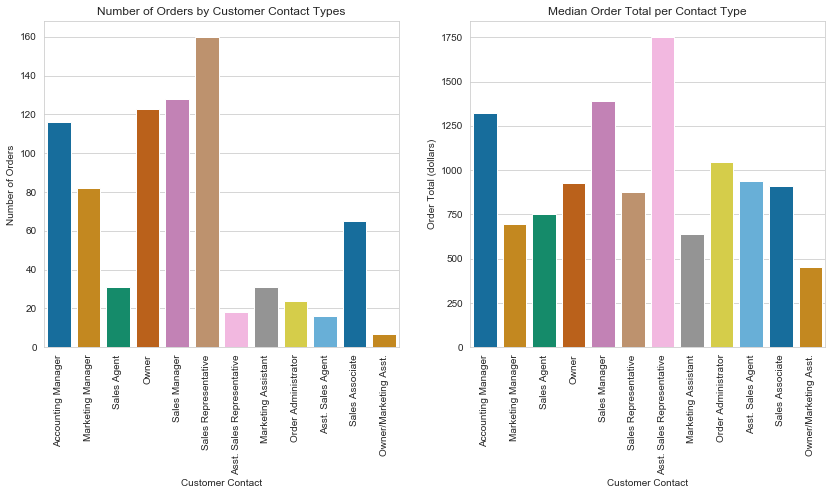

In [171]:
from numpy import median
fig, axes = plt.subplots(1,2, figsize=[14,6])

sns.countplot(contacts.Contact, palette='colorblind', ax=axes[0])
axes[0].set_xticks(np.arange(12))
axes[0].set_xticklabels(('Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner', 
                         'Sales Manager', 'Sales Representative', 'Asst. Sales Representative',
                         'Marketing Assistant', 'Order Administrator', 'Asst. Sales Agent', 'Sales Associate',
                         'Owner/Marketing Asst.'), 
          rotation=90)
axes[0].set_title('Number of Orders by Customer Contact Types')
axes[0].set_ylabel('Number of Orders')
axes[0].set_xlabel('Customer Contact')

# sns.barplot(x='Contact', y='Quantity', data=contacts, estimator=median, ci=0, palette='colorblind', ax=axes[1])
# #axes[1].set_xticklabels(np.arange(12), ('Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner', 
# #                          'Sales Manager', 'Sales Representative', 'Asst. Sales Representative',
# #                          'Marketing Assistant', 'Order Administrator', 'Asst. Sales Agent', 'Sales Associate',
# #                          'Owner/Marketing Asst.'), 
# axes[1].set_title('Median Order Quantity per Contact Type')
# axes[1].set_ylabel('Median Order Quantity')
# axes[1].set_xlabel('Customer Contact')

sns.barplot(x='Contact', y='Total', data=contacts, estimator=median, ci=0, palette='colorblind', ax=axes[1])
axes[1].set_xticks(np.arange(12))
axes[1].set_xticklabels(('Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner', 
                         'Sales Manager', 'Sales Representative', 'Asst. Sales Representative',
                         'Marketing Assistant', 'Order Administrator', 'Asst. Sales Agent', 'Sales Associate',
                         'Owner/Marketing Asst.'), 
          rotation=90)
axes[1].set_title('Median Order Total per Contact Type')
axes[1].set_xlabel('Customer Contact')
axes[1].set_ylabel('Order Total (dollars)')
plt.show()

# 4. Is there a difference in employee sales performance?

In [179]:
employee_main = join_3('Employee e', '[Order] o', 'OrderDetail d', '''e.LastName, e.Id, e.BirthDate, e.HireDate, 
e.Title, d.OrderId, d.UnitPrice, d.Quantity, d.Discount, o.OrderDate, o.Freight, o.CustomerId''', 'e.Id=o.EmployeeId',
                       'd.OrderId=o.Id')
employee_main.head()

2019-04-05 15:34:40,166 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, e.Id, e.BirthDate, e.HireDate, 
e.Title, d.OrderId, d.UnitPrice, d.Quantity, d.Discount, o.OrderDate, o.Freight, o.CustomerId FROM Employee e JOIN [Order] o on e.Id=o.EmployeeId JOIN OrderDetail d on d.OrderId=o.Id
2019-04-05 15:34:40,167 INFO sqlalchemy.engine.base.Engine ()


,LastName,Id,BirthDate,HireDate,Title,OrderId,UnitPrice,Quantity,Discount,OrderDate,Freight,CustomerId
0,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,10248,14.0,12,0.0,2012-07-04,32.38,VINET
1,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,10248,9.8,10,0.0,2012-07-04,32.38,VINET
2,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,10248,34.8,5,0.0,2012-07-04,32.38,VINET
3,Suyama,6,1995-07-02,2025-10-17,Sales Representative,10249,18.6,9,0.0,2012-07-05,11.61,TOMSP
4,Suyama,6,1995-07-02,2025-10-17,Sales Representative,10249,42.4,40,0.0,2012-07-05,11.61,TOMSP


In [180]:
emps = []
for order in employee_main.OrderId.unique():
    temp = employee_main.loc[employee_main.OrderId == order]
    quant = sum(temp.Quantity)
    tot = sum(temp.UnitPrice * temp.Quantity * (1-temp.Discount))
    emps.append([order, temp.OrderDate.max(), temp.LastName.max(), temp.Id.max(), temp.BirthDate.max(), temp.HireDate.max(), temp.Title.max(),
                quant, tot, temp.Discount.median(), temp.Freight.max(), temp.CustomerId.max()])
    
employees = pd.DataFrame(emps, columns=['Order', 'OrderDate','EmpName', 'EmpId', 'BirthDay', 'Hired', 'Title', 
                                        'Quantity', 'Total', 'Discount', 'Freight', 'CustomerId'])
employees.head()



,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD


In [181]:
employees.BirthDay = pd.to_datetime(employees.BirthDay)
employees.Hired = pd.to_datetime(employees.Hired)
age =  dt.datetime.now() - employees.BirthDay
#years = dt.datetime(2030, 4, 5) - emp_df.Hired
employees['Age'] = round(((age / np.timedelta64(1, 'D')).astype(int)) / 365, 2)
#emp_df['Tenure'] = round(((years / np.timedelta64(1, 'D')).astype(int)) / 365, 2)
employees.head()

,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId,Age
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET,32.11
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP,23.78
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR,49.58
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE,23.61
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD,49.58


In [182]:
# Because a comparison of the employee birthdays and order dates they managed suggests Northwind Trading violates
# child labor laws, the employees will be grouped into three age categories relative to stated birthdays

age_class = []

for age in employees.Age:
    if age <= 28:
        classification = 'Young'
    elif age > 28 and age <= 36:
        classification = 'Middle'
    else:
        classification = 'Relatively Old'
    age_class.append(classification)
    
employees['Age_Classification'] = age_class
employees.head()

,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId,Age,Age_Classification
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET,32.11,Middle
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP,23.78,Young
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR,49.58,Relatively Old
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE,23.61,Young
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD,49.58,Relatively Old


In [184]:
# Normality check of the distribution of order totals for each employee

# for name in employees.EmpName.unique():
#     distribution = employees.loc[employees.EmpName == name]
#     norm_check(distribution.Total, name)

In [185]:
employee_combos = list(itertools.combinations(employees.EmpName.unique(), 2))

In [188]:
# Variance check of order total distributions for employee combinations

# columns=['Employee1', 'Employee2', 'Variance_Test_p', 'Result']
# variance_check_multiple(employee_combos, employees, 'EmpName', 'Total', 'no', columns)

**Normality and Variance:** None of the order totals distributions were found to be normal according to the Shapiro-Wilks test and 22 of the 35 possible employee combinations exhibited unequal variance. Based on these results, hypothesis testing will be conducted under the assumption that the data is non-parametric.

**Statistical Testing:** Pairwise comparisons between each employee will be used to evaluate their sales performance in terms of order totals.

The null hypothesis for these tests is that there is no difference between the employees in terms of order totals.

The alternative hypothesis is that there is a difference between the employees in terms of order totals.

These tests are two-tailed to establish if there is a significnt difference between employees. The alpha value is 0.05.

In [193]:
columns = ['Employee1', 'Employee2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
compare_employees = stats_output(employee_combos, employees, 'EmpName', 'Total', columns)

# Drop combinations that did not reach significance
compare_employees.replace({'--': np.nan}, inplace=True)
compare_employees.dropna(inplace=True)
compare_employees



,Employee1,Employee2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
9,Suyama,Leverling,0.032309,0.196596,0.392447,-0.278116,0.196596,not significant
11,Suyama,Davolio,0.139189,0.031863,0.063529,-0.292024,0.031863,Significantly SMALLER


**Analysis:** Out of 36 possible employee combinations, only two yielded significant differences. Of those two combinations, only one acheived directional significance. The non-parametric function will calculate an effect size and test for directional significance if any one of the three initial two-tailed tests yield a p-value below 0.05. The Kolmogorov-Smirnov test returned significant results for Suyama-Levering, but the more powerful Mann-Whitney U and Kruskal-Wallis tests did not. Additionally, post-hoc directional testing with the Mann-Whitney U to determine if Suyama's order totals are significantly less than the order totals for Levering fialed to reach significance. These findings, along with the realtively small effect size suggest the difference in sales number between Suyama and Levering are not strong. Similarly, while Suyama's sales numbers were found to be significantly lower than Davolio's sales numbers, the effect size is relatively small and could be the result of low outliers for Suyama or high outliers for Davolio.

## 4a. Is there a difference in sales numbers based on employee age?

In [194]:
age_combos = list(itertools.combinations(employees.Age_Classification.unique(), 2))

In [196]:
# Normality check of order total distributions for age classifications

# for age in employees.Age_Classification.unique():
#     samp = employees.loc[employees.Age_Classification == age]
#     norm_check(samp.Total, age)

In [198]:
# Variance check of order total distributions for age classifications

# columns = ['Age_Class1', 'Age_Class2', 'Variance_Test_p', 'Result']
# variance_check_multiple(age_combos, employees, 'Age_Classification', 'Total', 'no', columns)


**Normality and Variance Check:** None of the distributions were normal according to the Shapiro-Wilks test and one of the age combinations had unequal variance. Based on these results, hypothesis testing will be conducted under the assumption that the data is non-parametric.

**Statistical Testing:** Pairwise comparisons of order totals will be made to determine if there is a difference between the three age classifications.

The null hypothesis is there is no difference in order totals between the different age classifications.

The alternative hypothesis is that there is a difference in order totals between the different age classifications.

These tests are two-tailed as they are determining significant differences between the age classifications. The alpha value is 0.05.

In [199]:
columns = ['Employee1', 'Employee2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(age_combos, employees, 'Age_Classification', 'Total', columns)

,Employee1,Employee2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,Middle,Young,0.472558,0.306610,0.613031,--,--,--
1,Middle,Relatively Old,0.409130,0.229950,0.459723,--,--,--
2,Young,Relatively Old,0.216564,0.098156,0.196227,--,--,--


**Analysis:** The tests indicate that there is no significant difference in order totals between age classifications. This suggests that experience does not play a significant role in order totals and that established employee training protocols are sufficient. However, due to the date discrepansy between recorded employee birthdays and order dates, drawing conclusions from these results should be cautioned as there may be data entry errors in the database.

## 4b. Do employees with more discounted sales generate higher sale totals?

In [201]:
no_discount = employees.loc[employees.Discount == 0]
yes_discount = employees.loc[employees.Discount > 0]

discount_counts = []

for employee in employees.EmpName.unique():
    sample = yes_discount.loc[yes_discount.EmpName == employee]
    sample2 = employees.loc[employees.EmpName == employee]
    num_discounts = len(sample)
    num_sales = len(sample2)
    percent_discounted = round((num_discounts / num_sales) * 100, 2)
    discount_counts.append([employee, num_sales, num_discounts, percent_discounted])

discount_per_employee = pd.DataFrame(discount_counts, columns=
                                     ['Employee', 'Number_of_Sales', 'Number_Sales_with_Discount', 'Percentage_Discounted'])
discount_per_employee

,Employee,Number_of_Sales,Number_Sales_with_Discount,Percentage_Discounted
0,Buchanan,42,23,54.76
1,Suyama,67,30,44.78
2,Peacock,156,71,45.51
3,Leverling,127,49,38.58
4,Dodsworth,43,21,48.84
5,Davolio,123,54,43.90
6,Callahan,104,48,46.15
7,Fuller,96,33,34.38
8,King,72,35,48.61


In [203]:
discount_class = []

for name in employees.EmpName:
    if name == 'Callahan' or name == 'Buchanan' or name == 'Dodsworth' or name == 'King':
        classification = 'More'
    else:
        classification = 'Fewer'
    discount_class.append(classification)
    
employees['Discount_Classification'] = discount_class
employees.head()

,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId,Age,Age_Classification,Discount_Given,Discount_Classification
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET,32.11,Middle,No,More
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP,23.78,Young,No,Fewer
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR,49.58,Relatively Old,Yes,Fewer
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE,23.61,Young,Yes,Fewer
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD,49.58,Relatively Old,Yes,Fewer


In [205]:
# Normality check order total distributions for each discount classification group of employees

# for classification in employees.Discount_Classification.unique():
#     group = employees.loc[employees.Discount_Classification == classification]
#     norm_check(group.Total, classification)

In [206]:
discount_class_combos = list(itertools.combinations(employees.Discount_Classification.unique(), 2))

In [235]:
# Variance check order total distributions between more a fewer discounts groups

# columns = ['Discount_Class1', 'Discount_Class2', 'Variance_Test_p', 'Result']
# variance_check_multiple(discount_class_combos, employees, 'Discount_Classification', 'Total', 'no', columns)

**Normality and Variance Check:** Neither distribution was normal according to the Shapiro-Wilks Test, but the variance between the sample was equal. Because the distributions were not normal, hypothesis testing will be conducted under the assumption that the data is non-parametric.

**Statistical Testing:** The distribution of order totals from employees that offer more discounts will be compared to the distribution of order totals from the employees that offer fewer discounts under the assumption (null hypothesis) that there is no difference between the distributions. The alternative hypothesis is that there is a difference between the two distributions. A two-tailed test will be used to determine if there is a significant difference with an alpha value of 0.05.

In [209]:
columns = ['Employee1', 'Employee2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'Kruskal_Wallis_p', 'Effect_Size',
          'Post_Hoc', 'Result']
stats_output(discount_class_combos, employees, 'Discount_Classification', 'Total', columns)

,Employee1,Employee2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,Kruskal_Wallis_p,Effect_Size,Post_Hoc,Result
0,More,Fewer,0.727946,0.28317,0.566235,--,--,--


**Analysis:** The tests indicate that there is no significant difference between the order totals of the employees who give more discounts and the order totals of the employees that give fewer discounts. This result suggests that discounts do not affect employee sales numbers.

## 4c. Do discounts affect sales numbers when evaluating employees individually?

In [214]:
# Normality check of the order total distributions for each employee with discounted and non-discounted order subsets

# for name in employees.EmpName.unique():
#     no_group = no_discount.loc[no_discount.EmpName == name]
#     yes_group = yes_discount.loc[yes_discount.EmpName == name]
#     norm_check(no_group.Total, f'No Discount - {name}')
#     norm_check(yes_group.Total, f'Discounted - {name}')

In [234]:
# Variance check for each employee's order totals distribution of discounted and non-discounted orders

# var_results = []

# for name in employees.EmpName.unique():
#     no_group = no_discount.loc[no_discount.EmpName == name]
#     yes_group = yes_discount.loc[yes_discount.EmpName == name]
    
#     p = variance_check(no_group.Total, yes_group.Total, 'no')
    
#     if p < 0.05:
#         r = 'UNEQUAL variance'
#     else:
#         r = 'EQUAL variance'
#     var_results.append([name, p, r])

# pd.DataFrame(var_results, columns=['Employee', 'Variance_Test_p', 'Result'])


**Normality and Variance Check:** None of the order total distributions were normal according to the Shapiro-Wilks test and only two employees had equal variance between their distributions. Based on these results, hypothesis testing will be conducted under the assumption that the data are non-parametric.

**Statistical Testing:** The order totals will be compared for each employee based on whether the order was discounted or not. The null hypothesis for each employee will be that there is no difference between the order totals that were discounted and the order totals that were not discounted. The alternative hypothesis will be that there is a difference between the order totals that were discounted and the order totals that were not discounted. These will be two-tailed tests and the alpha value will be 0.05.

In [211]:
def employee_compare(name):
    no_disc = no_discount.loc[no_discount.EmpName == name]
    yes_disc = yes_discount.loc[yes_discount.EmpName == name]
    
    np_result = non_parametric(no_disc.Total, yes_disc.Total)
    print(name)
    print(f"Kolmogorov-Smirnov p-value: {np_result[0][0]}")
    print(f"Mann_WhitneyU p-value: {np_result[0][1]}")
    print(f"Kruskal-Wallis p-value: {np_result[0][2]}")
    print(f"Effect Size: {np_result[0][3]}")
    print(f'Post-Hoc: {np_result[0][4]}')
    print(f'Result: {np_result[0][5]}')
    
    fig = plt.figure(figsize=[10,6])
    sns.distplot(no_disc.Total, color='purple', label='No Discount')
    plt.axvline(no_disc.Total.mean(), color='darkorchid')
    sns.distplot(yes_disc.Total, color='green', label='Discounts')
    plt.axvline(yes_disc.Total.mean(), color='darkgreen')
    plt.title(name)
    plt.legend()
    plt.show()

Buchanan
Kolmogorov-Smirnov p-value: 0.9074327889692138
Mann_WhitneyU p-value: 0.43974189228371163
Kruskal-Wallis p-value: 0.8695272985205063
Effect Size: --
Post-Hoc: --
Result: --


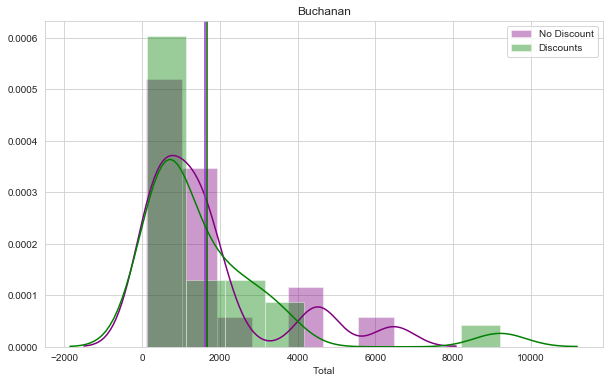

Suyama
Kolmogorov-Smirnov p-value: 0.5291423343581874
Mann_WhitneyU p-value: 0.12431002380463368
Kruskal-Wallis p-value: 0.24604389571845794
Effect Size: --
Post-Hoc: --
Result: --


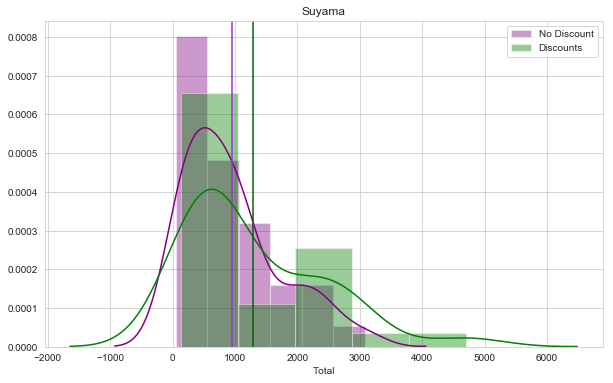

Peacock
Kolmogorov-Smirnov p-value: 0.001766122031040597
Mann_WhitneyU p-value: 0.0002469324888548783
Kruskal-Wallis p-value: 0.0004905916851573195
Effect Size: -0.47611897580382295
Post-Hoc: 0.0002469324888548783
Result: Significantly SMALLER


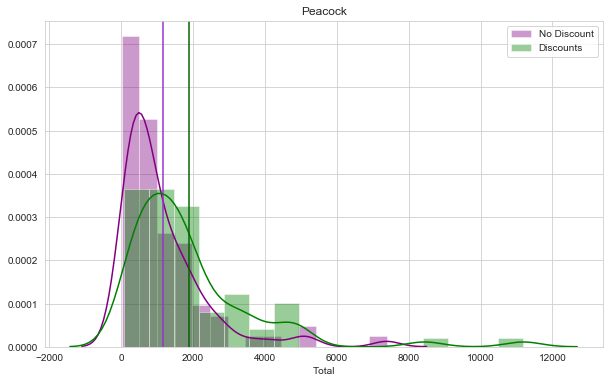

Leverling
Kolmogorov-Smirnov p-value: 0.0763963385516411
Mann_WhitneyU p-value: 0.052136540074130225
Kruskal-Wallis p-value: 0.10374604603754903
Effect Size: --
Post-Hoc: --
Result: --


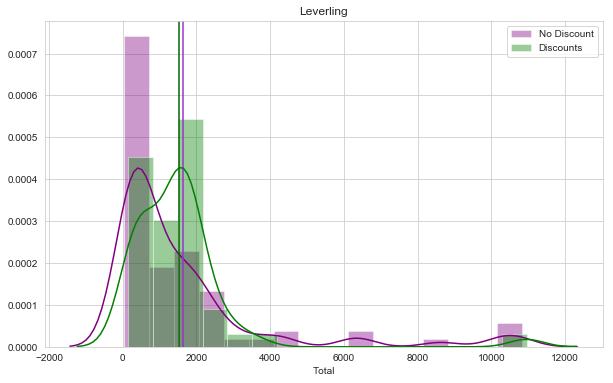

Dodsworth
Kolmogorov-Smirnov p-value: 0.22275647902891743
Mann_WhitneyU p-value: 0.1811166358381699
Kruskal-Wallis p-value: 0.3558685451916669
Effect Size: --
Post-Hoc: --
Result: --


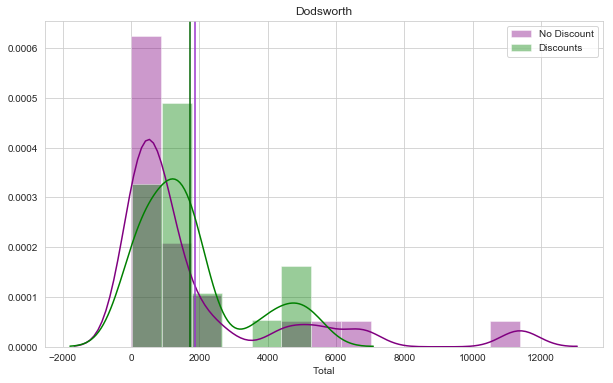

Davolio
Kolmogorov-Smirnov p-value: 0.8130653567900793
Mann_WhitneyU p-value: 0.4766322072132264
Kruskal-Wallis p-value: 0.9512349116685275
Effect Size: --
Post-Hoc: --
Result: --


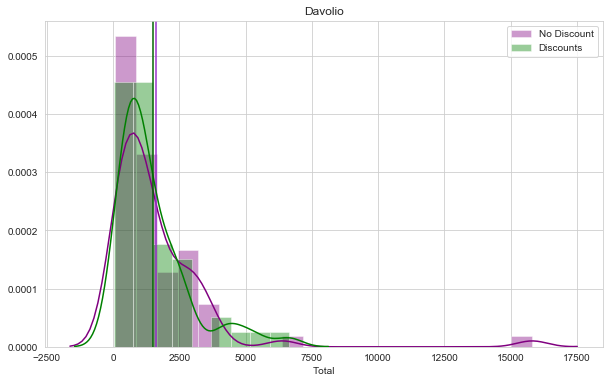

Callahan
Kolmogorov-Smirnov p-value: 0.5809598804296628
Mann_WhitneyU p-value: 0.34420595438745166
Kruskal-Wallis p-value: 0.6860131458138695
Effect Size: --
Post-Hoc: --
Result: --


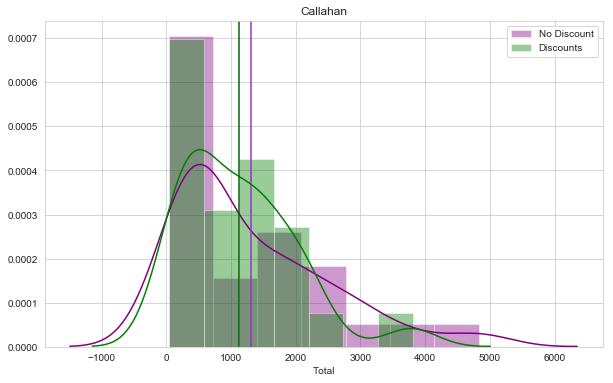

Fuller
Kolmogorov-Smirnov p-value: 0.006347438623815532
Mann_WhitneyU p-value: 0.0004676648109364381
Kruskal-Wallis p-value: 0.0009225254436569678
Effect Size: -0.501920528788615
Post-Hoc: 0.0004676648109364381
Result: Significantly SMALLER


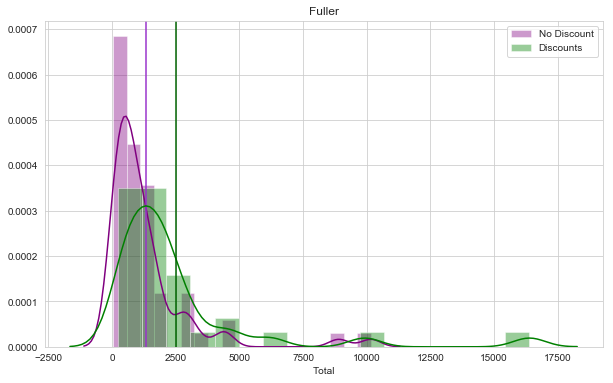

King
Kolmogorov-Smirnov p-value: 0.19617213189698818
Mann_WhitneyU p-value: 0.033144688987629796
Kruskal-Wallis p-value: 0.06546122900173672
Effect Size: -0.4747086183310023
Post-Hoc: 0.033144688987629796
Result: Significantly SMALLER


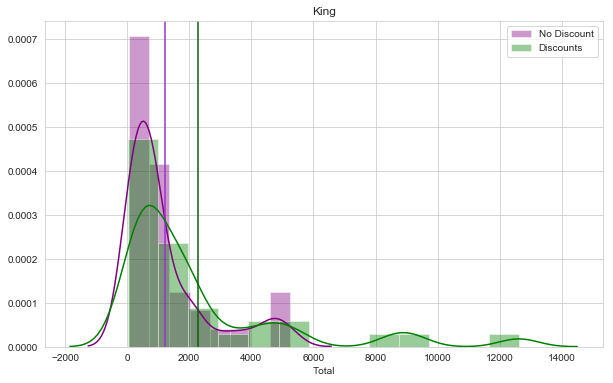

In [212]:
for employee in employees.EmpName.unique():
    employee_compare(employee)

**Analysis:** The tests indicate that employees Peacock, Fuller, and King all have significantly higher order totals when they discount the order as opposed to when they do not discount an order. The effect sizes for these employees range from 0.48 to 0.50, indicating that the effect of discounts is moderate. These results suggest that discounting orders can aid certain employees in generating larger sales. Resources should be directed towards training employees to offer discounts with the aim of increasing sales numbers.

# Conclusion: Employees

Employee sales number do not differ significantly amoung all but two employee comparisons. This suggests that established training protocols are adequate in giving employees an equal skill set and no additional resources need to be directed towards modifying these protocols for new employees. However, the sales numbers of several employees benefitted from including discounts in their sales. Resources should be directed towards training employees on how to incorporate discounts in a deal with the aim of driving up sales numbers.

# Project Summary

This project attempted to evaluate the overall health of the Northwind Trading Company, by examining several aspects of company sales and logistics. First, the affect of discounts on sale quantity and sale totals was evaluated. Discounted sales are significantly higher in both quantity and total price, with discounts having a stronger effect on order quantity (effect size: 0.40) than on order total (effect size: 0.17). The offered discounts were grouped into five groups (< 5%, 5-10%, 10-15%, 15-20%, and 20-25%) representing different levels of discounts (5%, 10%, 15%, 20%, 25%). All levels of discounts significantly increased quantity, with the 25% discount group having the strongest effect (effect size: 0.57). The 5%, 15%, and 25% discount groups all significantly increased order total, with 5% discounts having the strongest effect on order total (effect size: 0.31). Based on these findings, it is recommended to discount orders by 25% if the objective is to move large quantities of items and to discount orders by 5% if the objective is to increase sale totals. It should be noted that the 25% discount group had the second largest effect (effect size: 0.28) on sale totals, thus 25% discounts should be applied if the objective is to both move larger quantities of products and increase sale totals.

The order totals were analyzed based on the customer contact associated with each order to determine if a particular type of contact should be targeted within current and prospective customer companies to drive up sales numbers. The sample dataset used for this project contained 12 different customer contact titles representing various positions within the corporate hierarchy. The number of orders placed by each title ranged from 7-160, thus the titles were logically grouped into for categories based on similar levels within the corporate hierarchy. No statistical difference was found in terms of order totals between the four groups of customer contacts, suggesting that any contact that can be made with prospective customers should be persued, regardless of position within the company. However, more data should be collected to further evaluate the individual customer contact titles, instead of the grouped contact types as there does appear to be trends that failed to reach significance in this project.

A thorough analysis of the three shipping companies utilized by Northwind Trading was conducted to determine if there was a difference in cost and performance between them. Overall, there is no difference in shipping costs between the three companies. But, some differences were found when the shipping costs for each company were evaluated by geographical region. For orders handled by Speedy Express, shipping costs are significantly higher for orders going to Western Europe than for three of the other five regions. The United Package shipping company had the fewest differences in shipping costs between the regions (3, all involving the Northern Europe/Scandinavia group) and Federal Shipper had the most number of differences in shipping costs between the regions (8, mostly involving Western Europe and North America). Federal Shipper has a significantly lower order processing time than the other two shipping companies, and this speed of processing is not affect by the quantity of the order. Thus, since all three shipping companies deliver to all six geographical regions, it would be reasonable to use one shipping company exclusively. If shipping costs vary wildly from one fiscal year to the next (making budgeting predictions challenging), it is recommended to select United Package as the exclusive shipper of Northwind Trading as its shipping costs vary the least between regions and there is no significant difference in overall shipping cost from the other two shipping companies. If all shipping companies will be utilized moving forward, it would be prudent to evaluate the shipping cost between each company per region to determine if there is a significant difference in cost per region and thus divide responsibilities between the companies.

Lastly, the sales numbers for each employee were evaluated to determine if any suggestions can be made to training protocols with the aim of increasing team effectiveness. In terms of order totals, there is no strong, significant difference between the nine employees evaluated in this dataset. This finding suggests that established training protocols provide adequate, basic skills equally to employees. However, for three employees, the order totals were significantly larger for discounted orders than non-discounted orders. This suggests that resources should be directed to training employees on how to incorporate discounts into orders to encourage the customer to spend more.

It should be noted that the statistical analyses conducted in this project adhered to a strict classification of non-parametric data if most of the subsamples in an analysis were found to be not normally distributed (by Kolmogorov-Smirnov and Shapiro-Wilks testing) or if most of the subsample combinations had unequal variance. This was to ensure that no assumptions were violated for any statistical test used and thus increasing confidence of statistical significance. However, this decision comes at a cost in that parametric tests are more robust than non-parametric tests. Therefore, some significant trends may be present in this dataset, but failed to reach significance because non-parametric tests were used. Because the assumptions of normality and equal variance can be relaxed for most parametric tests, it would be prudent to evaluate this data under parametric assumptions to see if findings hold and if new findings can be uncovered.

# Future Work

* Evaluate the spending response of each customer to various discounts to predict what levels of discounts most encourage increased spending, ultimately tailoring discount offers to customers.
* Evaluate the affect a supplier has on order processing time for orders that failed to ship by the required date to determine which component contributed more to the delay.
* Determine the difference in shipping cost for each shipping company to the respective to different customer regions in an effort to divide shipping responsibilities between the companies in a manner that minimizes costs.